## intake + kerchunk

In [1]:
import intake

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
cat = intake.open_catalog("/home/datawork-lops-iaocea/catalog/intake/gulfstream_gigatl1_1h_tides.yaml")

ds = (
    cat["1h_tides"].to_dask()
)

In [4]:
mask = ds.mask_rho.load()
mask_psi = ds.mask_rho.isel(xi_rho=slice(0,-1),eta_rho=slice(0,-1)).swap_dims({"xi_rho": "xi_u"}).swap_dims({"eta_rho": "eta_v"}).load()
u = ds.u.isel(time=slice(0,1464,128),s_rho=-1).transpose('time','eta_rho', 'xi_u')
v = ds.v.isel(time=slice(0,1464,128),s_rho=-1).transpose('time','eta_v', 'xi_rho')
ssh = ds.temp.isel(time=slice(0,1464,128),s_rho=-1).transpose('time','eta_rho', 'xi_rho')
vrt = v.diff(dim='xi_rho').swap_dims({"xi_rho": "xi_u"}) -  u.diff(dim='eta_rho').swap_dims({"eta_rho": "eta_v"})

In [5]:
temp = vrt.where(mask_psi).compute()
#stmp = ssh.where(mask_psi).compute()
temp=np.array(temp)

In [6]:
XSIZE=128
nt,nx,ny=temp.shape
print(nt,nx,ny)

NN=4096
xx=np.zeros([NN,NN])
yy=np.ones([NN,NN])
xx[0:XSIZE//2,0:XSIZE//2]=1.0
xx[-XSIZE//2:,0:XSIZE//2]=1.0
xx[0:XSIZE//2,-XSIZE//2:]=1.0
xx[-XSIZE//2:,-XSIZE//2:]=1.0
yy[NN//2-nx//2:NN//2-nx//2+nx,NN//2-ny//2:NN//2-ny//2+ny]=np.isnan(temp[0])==True
histo=(np.fft.ifft2(np.fft.fft2(xx)*np.fft.fft2(yy)).real)[NN//2-nx//2:NN//2-nx//2+nx,NN//2-ny//2:NN//2-ny//2+ny]

12 840 1575


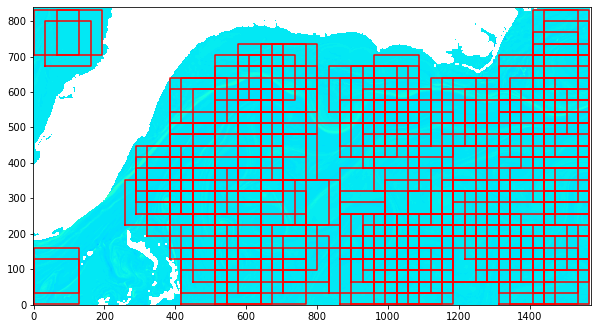

In [7]:
idx=np.zeros([2,nx*ny],dtype='int')
k=0
for i in range(XSIZE//2+1,nx-XSIZE//2,XSIZE//4):
    for j in range(XSIZE//2+1,ny-XSIZE//2,XSIZE//4):
        if histo[i,j]==0.0:
            vv=temp[:,i-XSIZE//2:i+XSIZE//2,j-XSIZE//2:j+XSIZE//2].reshape(nt,XSIZE*XSIZE)
            if np.sum(np.isnan(np.mean(vv,1))==False)==nt:
                idx[0,k]=i
                idx[1,k]=j
                k=k+1
idx=idx[:,0:k]
f=plt.figure(figsize=(10,10))
plt.imshow(temp[0,:,:],cmap='jet',origin='lower')
for i in range(idx.shape[1]):
    plt.plot([idx[1][i]-XSIZE//2,idx[1][i]-XSIZE//2,idx[1][i]+XSIZE//2,idx[1][i]+XSIZE//2,idx[1][i]-XSIZE//2],
            [idx[0][i]-XSIZE//2,idx[0][i]+XSIZE//2,idx[0][i]+XSIZE//2,idx[0][i]-XSIZE//2,idx[0][i]-XSIZE//2],color='red')
    
nfield=idx.shape[1]
data=np.zeros([nfield*nt,XSIZE,XSIZE])

for j in range(nt):
    for i in range(nfield):
        data[j*nfield+i,:,:]=temp[j,idx[0,i]-XSIZE//2:idx[0,i]+XSIZE//2,idx[1,i]-XSIZE//2:idx[1,i]+XSIZE//2]
        
amean=data.mean()
vmean=data.std()
data=data-amean
data=data/vmean
        
nfield=nfield*nt

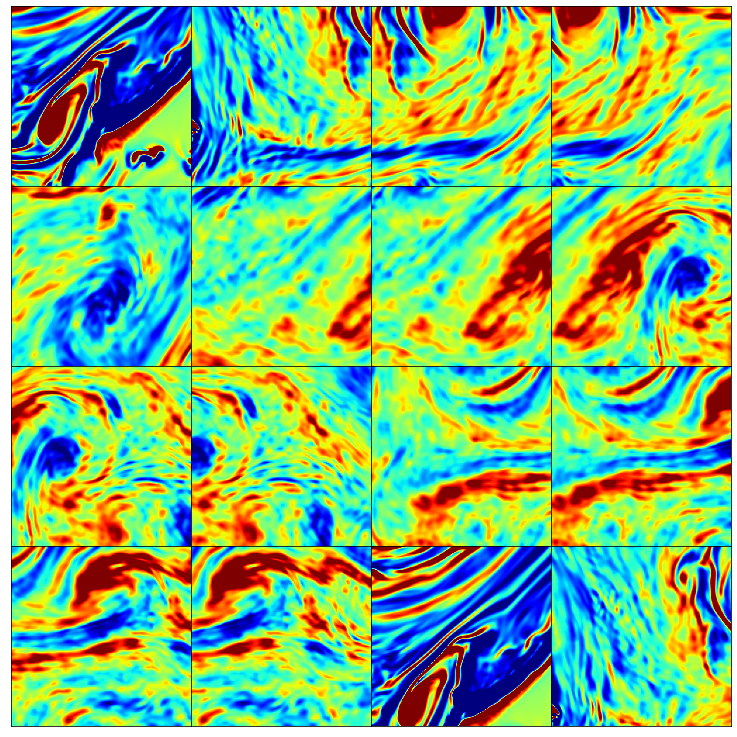

In [8]:
f=plt.figure(figsize=(10,10))
f.subplots_adjust(hspace=0.,wspace=0.,left=0.0,right=1.0,top=1.0,bottom=0.0)
for i in range(16):
    ax=plt.subplot(4,4,1+i)
    plt.imshow(data[i,:,:],cmap='jet',aspect='auto',origin='lower',vmin=-1,vmax=1)
    ax.set_yticks([])
    ax.set_xticks([])
new_temp=data.reshape(nfield,XSIZE*XSIZE)

# DEFINE 2D SCATTERING FUNCTION

In [9]:
def scatter_wave(x,norient=16,doplot=False):
    nx,ny=x.shape
    n2data=int(np.log(nx)/np.log(2))
    nstep=n2data-1
    print('NSTEP ',nstep)
    val={}
    
    if doplot:
        f=plt.figure(figsize=(16,16))
        f.subplots_adjust(hspace=0.,wspace=0.,left=0.0,right=1.0,top=1.0,bottom=0.0)
        
    for i in range(nstep):
        xsize=2**(n2data-i)
        print(xsize)
        xx=np.repeat(np.roll(np.arange(xsize)-xsize/2,xsize//2)/(xsize/2),xsize).reshape(xsize,xsize)
        yy=xx.T
        ang=np.arctan2(yy,xx)
        
        for j in range(norient):
            a=np.pi/norient*j
            #val[i,j]=np.exp(-8*((xx*np.cos(a)+yy*np.sin(a)-2**(-i-1))**2+(xx*np.sin(a)-yy*np.cos(a))**2))
            val[i,j]=(xx**2+yy**2)*np.exp(-(xx**2+yy**2))*(np.exp(-4*(ang+a)**2)+np.exp(-4*(ang+a-2*np.pi)**2))
            val[i,j][0,0]=0.0
            
            if doplot:
                ax=plt.subplot(nstep,norient,1+i*norient+j)
                plt.imshow(val[i,j],cmap='jet',aspect='auto',origin='lower')
                ax.set_yticks([])
                ax.set_xticks([])
            
    return(val)
    
def scatter2D(x,val,norient=16,doplot=False,norm=False):
    nx,ny=x.shape
    
    tf=np.roll(np.roll(np.fft.fft2(x),nx//2,0),nx//2,1)
    
    n2data=int(np.log(nx)/np.log(2))
    nstep=n2data-1
    
    s1=np.zeros([nstep,norient])
    nn=norient*(nstep)
    s2=np.zeros([nstep*norient*nn])
    j1=np.zeros([nstep*norient*nn],dtype='int')
    j2=np.zeros([nstep*norient*nn],dtype='int')
    o1=np.zeros([nstep*norient*nn],dtype='int')
    o2=np.zeros([nstep*norient*nn],dtype='int')
    
    nn=0
    if doplot:
        f=plt.figure(figsize=(16,16))
        f.subplots_adjust(hspace=0.,wspace=0.,left=0.0,right=1.0,top=1.0,bottom=0.0)
        
    for i in range(nstep):
        nnn=2**(n2data-i)
        tf2=2**(-i)*np.roll(np.roll(tf[nx//2-nnn//2:nx//2+nnn//2,nx//2-nnn//2:nx//2+nnn//2],-nnn//2,0),-nnn//2,1)
        for j in range(norient):
            tmp=abs(np.fft.ifft2(tf2*val[i,j]))       
            
            if doplot:
                ax=plt.subplot(nstep,norient,1+i*norient+j)
                plt.imshow(tmp,cmap='jet',aspect='auto',origin='lower')
                ax.set_yticks([])
                ax.set_xticks([])
            s1[i,j]=tmp[nnn//4:-nnn//4,nnn//4:-nnn//4].mean()
                    
            ltf2=np.fft.fft2(tmp)
            for k in range(nstep-i-1):
                nnn2=2**(n2data-i-k-1)
                tf3=np.roll(np.roll(ltf2[nnn//2-nnn2//2:nnn//2+nnn2//2,nnn//2-nnn2//2:nnn//2+nnn2//2],-nnn2//2,0),-nnn2//2,1)
                for l in range(norient):
                    tmp2=abs(np.fft.ifft2(val[k+i+1,(j+l)%norient]*tf3))
                    j1[nn]=i
                    j2[nn]=k+i+1
                    o1[nn]=j
                    o2[nn]=(j+l)%norient
                    s2[nn]=tmp2[nnn2//4:-nnn2//4,nnn2//4:-nnn2//4].mean()
                    nn+=1
        
    s2=s2[0:nn]
    j1=j1[0:nn]
    j2=j2[0:nn]
    o1=o1[0:nn]
    o2=o2[0:nn]
    
    if norm==True:
        s1=np.mean(s1,1)
        ws2=np.bincount((j2-j1-1)*norient+(o2-o1+norient)%norient,weights=s2)
        ns2=np.bincount((j2-j1-1)*norient+(o2-o1+norient)%norient)
        s2=ws2/ns2
        return(s1,s2)
    else:
        return(s1,s2,j1,j2,o1,o2)

In [10]:
val=scatter_wave(data[0,:,:])
s1,s2=scatter2D(data[0,:,:],val,norm=True)
n1=s1.shape[0]
n2=s2.shape[0]
n=n1+n2

scat=np.zeros([nfield,n])
nb=0
for i in range(nfield):
    if i>(nb*nfield)//100:
        print("%2d %% Done"%(nb))
        nb+=5
    s1,s2=scatter2D(data[i,:,:],val,norm=True)
    scat[i,0:n1]=s1.flatten()
    scat[i,n1:]=s2.flatten()
    
print('Done')

NSTEP  6
128
64
32
16
8
4
 0 % Done
 5 % Done
10 % Done
15 % Done
20 % Done
25 % Done
30 % Done
35 % Done
40 % Done
45 % Done
50 % Done
55 % Done
60 % Done
65 % Done
70 % Done
75 % Done
80 % Done
85 % Done
90 % Done
95 % Done
Done


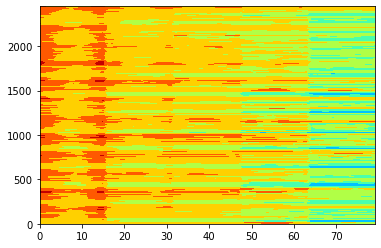

In [11]:
plt.contourf(np.log(scat[:,n1:]),cmap='jet')

In [12]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

ncluster=4

acp = PCA(n_components=2)
y=acp.fit_transform(np.log(scat[:,n1:]))

kmeans = KMeans(init="random",n_clusters=ncluster,n_init=10,max_iter=300,random_state=42)
kmeans.fit(y)


KMeans(init='random', n_clusters=4, random_state=42)

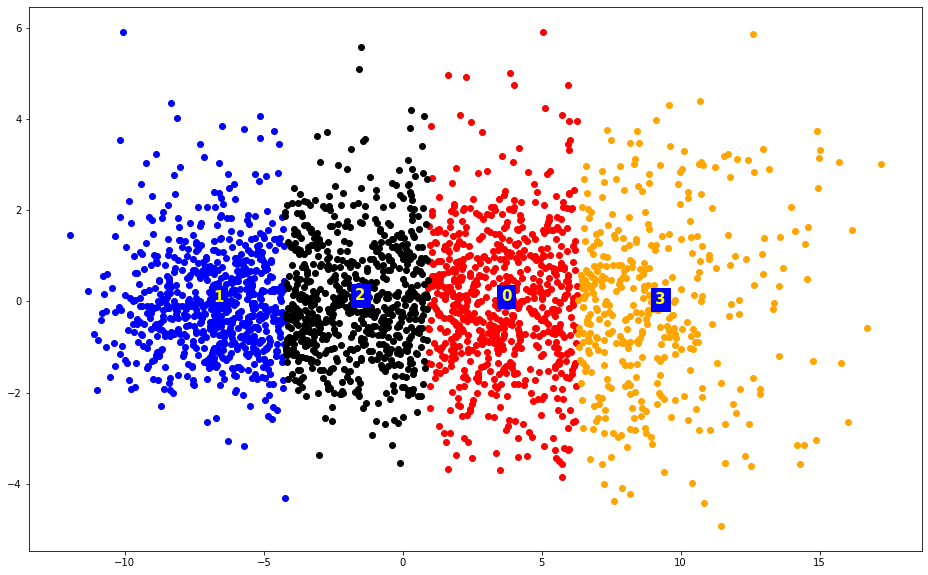

In [13]:
color=['red','blue','black','orange','yellow','purple','darkblue','darkred']
plt.figure(figsize=(16,10))
for i in range(ncluster):
    plt.scatter(y[kmeans.labels_==i,0],y[kmeans.labels_==i,1],color=color[i])
    plt.text(y[kmeans.labels_==i,0].mean(),y[kmeans.labels_==i,1].mean(),'%d'%(i),fontsize=15,fontweight='bold',backgroundcolor='blue',color='yellow')

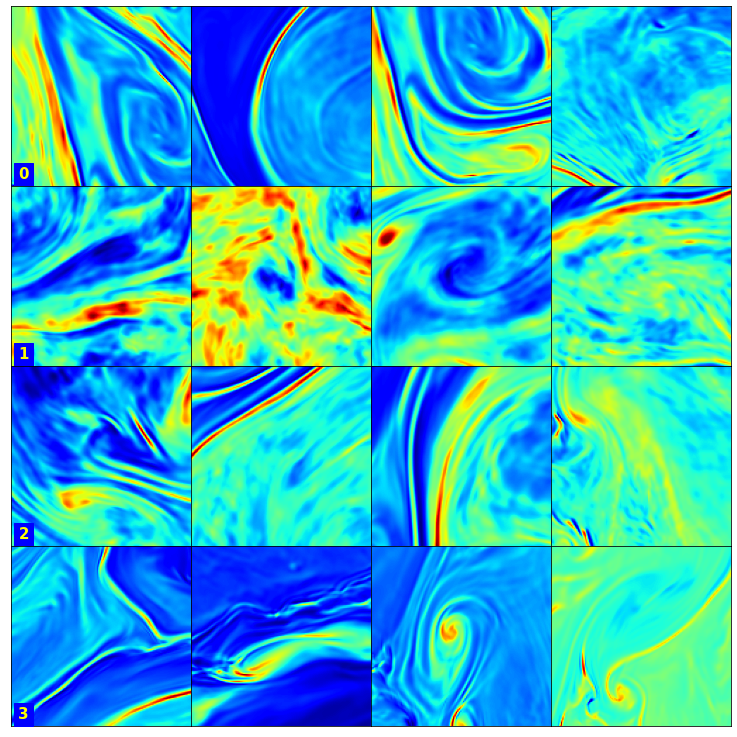

In [14]:
f=plt.figure(figsize=(10,10))
f.subplots_adjust(hspace=0.,wspace=0.,left=0.0,right=1.0,top=1.0,bottom=0.0)
for i in range(ncluster):
    x0=y[kmeans.labels_==i,0].mean()
    y0=y[kmeans.labels_==i,1].mean()
    iii=np.argsort((y[:,0]-x0)**2+(y[:,1]-y0)**2)
    for j in range(4):
        ax=plt.subplot(ncluster,4,1+4*i+j)
        plt.imshow(data[iii[j]][:,:],cmap='jet',aspect='auto',origin='lower')
        ax.set_yticks([])
        ax.set_xticks([])
        if j==0:
            plt.text(5,5,'%d'%(i),fontsize=15,fontweight='bold',backgroundcolor='blue',color='yellow')

In [33]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

ncluster=4

acp = TSNE(n_components=2)
y=acp.fit_transform(np.log(scat[:,:]))

kmeans = KMeans(init="random",n_clusters=ncluster,n_init=1,max_iter=300,random_state=42)
kmeans.fit(y)


/home/datawork-lops-iaocea/conda-env/cpu/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/datawork-lops-iaocea/conda-env/cpu/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


KMeans(init='random', n_clusters=4, n_init=1, random_state=42)

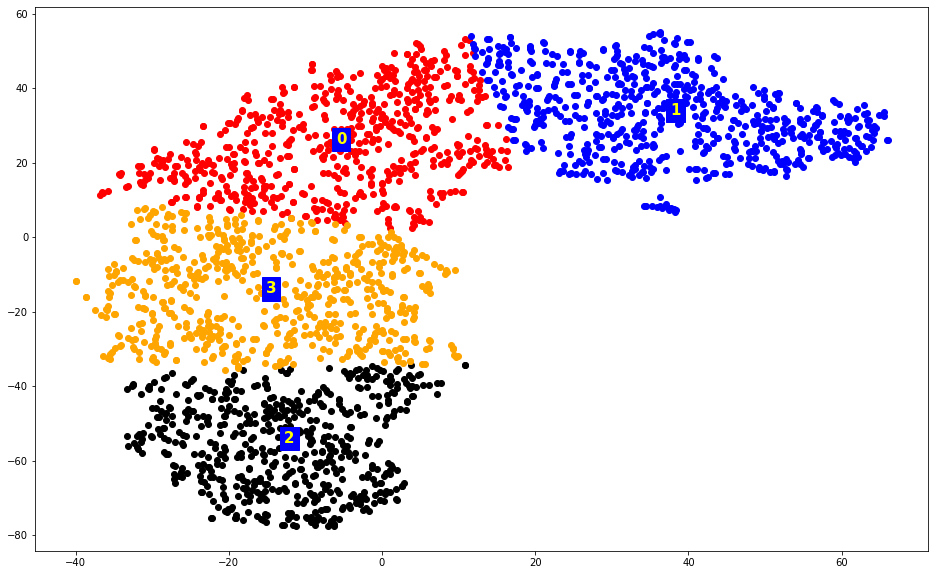

In [34]:

color=['red','blue','black','orange','yellow','purple','darkblue','darkred']
plt.figure(figsize=(16,10))
for i in range(ncluster):
    plt.scatter(y[kmeans.labels_==i,0],y[kmeans.labels_==i,1],color=color[i])
    plt.text(y[kmeans.labels_==i,0].mean(),y[kmeans.labels_==i,1].mean(),'%d'%(i),fontsize=15,fontweight='bold',backgroundcolor='blue',color='yellow')

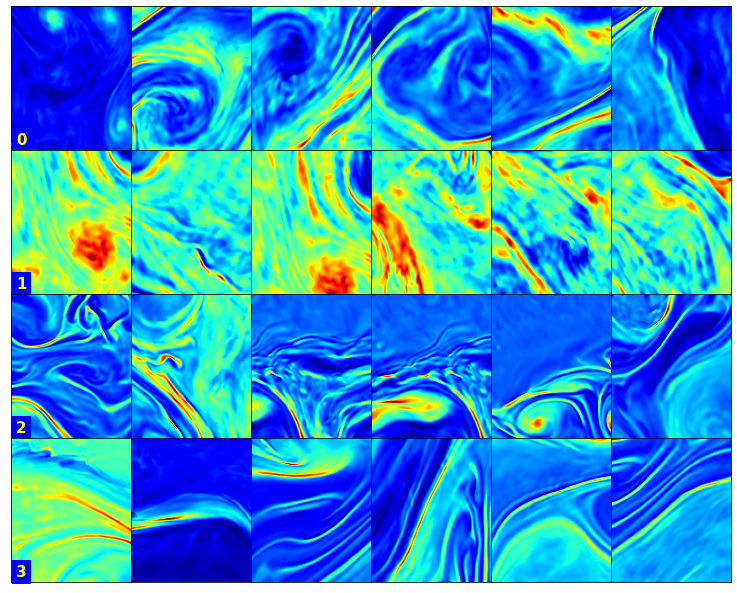

In [35]:
f=plt.figure(figsize=(10,8))
f.subplots_adjust(hspace=0.,wspace=0.,left=0.0,right=1.0,top=1.0,bottom=0.0)
for i in range(ncluster):
    x0=np.median(y[kmeans.labels_==i,0])
    y0=np.median(y[kmeans.labels_==i,1])
    iii=np.argsort((y[:,0]-x0)**2+(y[:,1]-y0)**2)
    for j in range(6):
        ax=plt.subplot(ncluster,6,1+6*i+j)
        plt.imshow(data[iii[j]][:,:],cmap='jet',aspect='auto',origin='lower')
        ax.set_yticks([])
        ax.set_xticks([])
        if j==0:
            plt.text(5,5,'%d'%(i),fontsize=15,fontweight='bold',backgroundcolor='blue',color='yellow')

# Affichage des deux coordonées de t-SNE

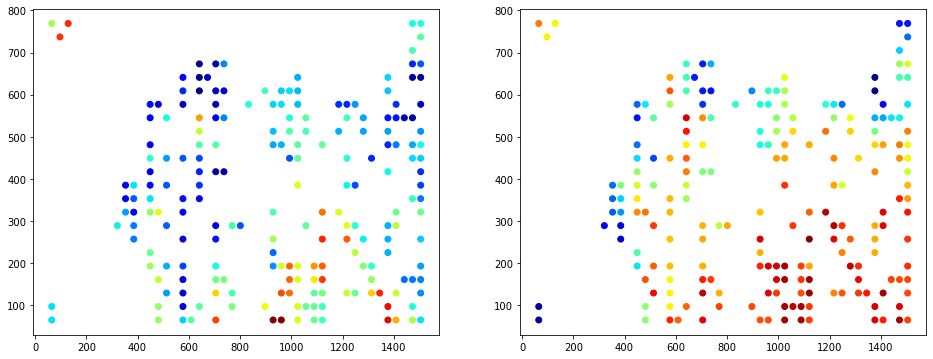

In [36]:
y=y.reshape(nt,y.shape[0]//nt,2)
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(idx[1],idx[0],c=y[0,:,0],cmap='jet')
plt.subplot(1,2,2)
plt.scatter(idx[1],idx[0],c=y[0,:,1],cmap='jet')

# Affichage des clusters déterminés par k-means

In [42]:
lab=kmeans.labels_.reshape(nt,y.shape[1])
plt.figure(figsize=(12,8))
for i in range(ncluster):
    plt.scatter(idx[1][kmeans.labels_==i],idx[0][kmeans.labels_==i],cmap='jet',color=color[i])

IndexError: boolean index did not match indexed array along dimension 0; dimension is 204 but corresponding boolean dimension is 2448

<Figure size 864x576 with 0 Axes>

In [43]:
import matplotlib.pyplot as plt
import kymatio as ky
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torch import optim
from scipy.misc import face

from kymatio.torch import Scattering2D

device = "cuda" if torch.cuda.is_available() else "cpu"

ModuleNotFoundError: No module named 'kymatio'